This script compares the impact of increasing the number of edges in random small world graphs. Since the theoretical motivation behind our approach relies on graphins, we expect that increasing the density of edges will hinder the performance. In addition, our proposed method is compared with other baselines.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLasso

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import spectral_nti as snti

# %matplotlib qt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [9]:
def run_exp(id, models, KK, iters):
    L_hat = np.zeros((N, N, len(models), len(KK)))
    lamd_hat = np.zeros((N, len(models), len(KK)))
    Ls = np.zeros((N, N, len(KK)))
    lamds = np.zeros((N, len(KK)))
    for i, k in enumerate(KK):
        # Create graphs
        A0 = nx.to_numpy_array(nx.watts_strogatz_graph(N0, k, p, seed=SEED))
        L0 = np.diag(np.sum(A0, 0)) - A0
        lambdas0, _ = np.linalg.eigh(L0)

        A = nx.to_numpy_array(nx.watts_strogatz_graph(N, k, p))
        Ls[:,:,i] = np.diag(np.sum(A, 0)) - A
        lamds[:,i], V = np.linalg.eigh(Ls[:,:,i])

        cs_err = np.zeros(len(models))
        for l, model in enumerate(models):
            if model['name'] in ['MGL-Tr', 'MGL-Sq', 'MGL-Heat', 'MGL-Poly']:
                model['cs'], cs_err[l] = utils.compute_cs(model['gs'], lambdas0, lamds[:,i])
            elif model['name'] == 'MGL-Tr=1':
                model['cs'] = 1
            elif model['name'] == 'MGL-Tr=N':
                model['cs'] = N

        # Create signals
        lambdas_aux = np.concatenate(([0], 1/np.sqrt(lamds[1:,i])))
        C_inv_sqrt = V@np.diag(lambdas_aux)@V.T
        X = C_inv_sqrt@np.random.randn(N, M)
        C_hat = X@X.T/M

        # Estimate graph
        for j, model in enumerate(models):
            t = time.time()
            L_hat[:,:,j,i], _ = \
                snti.SGL_MM(C_hat, model['gs'], model['bounds'],
                            model['cs'], model['regs'], max_iters=iters)
                            
            lamd_hat[:,j,i], _ = np.linalg.eigh(L_hat[:,:,j,i])
            t = time.time() - t
            print('Graph-{}, k-{}: Model: {} - cs: {:.4f} - Time(sec): {:.3}'.
                  format(id, k, model['name'], cs_err[j], t))
    return L_hat, lamd_hat, Ls, lamds


def est_errs2(Ls, lamds, L_hat, lams_hat):
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            L = Ls[:,:,i,k]
            lamd = lamds[:,i,k]
            norm_L = np.linalg.norm(L, 'fro')
            norm_lam = np.linalg.norm(lamd, 2)

            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')**2
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)**2
    return err_L, err_lamb


def plot_err(KK, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(KK, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(KK, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Mean node degree')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([KK[0], KK[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


## Constants

In [3]:
# Graph params
p = .1
N0 = 150
N = 100
M = 500

n_graphs = 50
KK = [4, 8, 12, 16, 20, 24, 28, 32]
iters = 200

GS = [
    lambda a, b : cp.sum(a)/b,    # delta: 4e-2
    lambda a, b : cp.sum(a**2)/b,  # delta: .7
    lambda a, b : cp.sum(cp.exp(-a))/b,    # delta: 3e-3
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

deltas = [1e-3, .3, .005, .1]

models = [
    # Baselines
    # {'name': 'GLasso'},
    # {'name': 'GGL'},
    # {'name': 'SGL'},
    {'name': 'MGL-Tr=N', 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 1e-4, 'beta': 0.5, 'gamma': 0, 'deltas': deltas[0]}},

    # Our algorithms
    {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 0.2, 'gamma': 0, 'deltas': deltas[0]}},

    {'name': 'MGL-Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
     'regs': {'alpha': 0, 'beta': 0.1, 'gamma': 5000, 'deltas': deltas[1]}},

    {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
     'regs': {'alpha': 0, 'beta': 0.2, 'gamma': 1, 'deltas': deltas[2]}},

    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 0.1, 'gamma': 10000, 'deltas': deltas[0]}},
]

## Compare contraints

In [4]:
# Estimate graph
total_t = time.time()
Ls = np.zeros((N, N, len(KK), n_graphs))
lamds = np.zeros((N, len(KK), n_graphs))
Ls_hat = np.zeros((N, N, len(models), len(KK), n_graphs))
lamds_hat = np.zeros((N, len(models), len(KK), n_graphs))
print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, models, KK, iters) for i in range(n_graphs))


for i, resp in enumerate(resps):
    Ls_hat[:,:,:,:,i], lamds_hat[:,:,:,i], Ls[:,:,:,i], lamds[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12


ValueError: could not broadcast input array from shape (100,100,6,4) into shape (100,100,4)

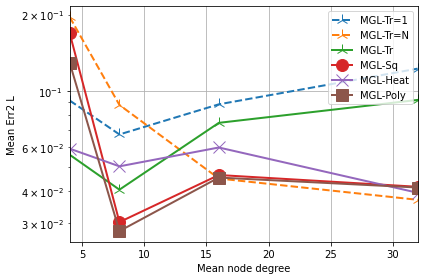

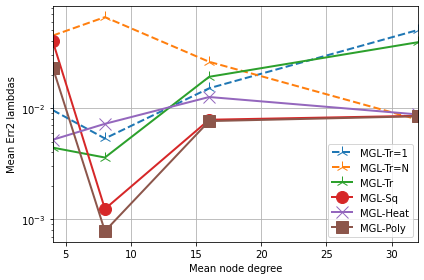

In [10]:
err_L, err_lamb = est_errs2(Ls, lamds, Ls_hat, lamds_hat)
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(KK, models, mean_err_L, 'Mean Err2 L')
plot_err(KK, models, mean_err_lam, 'Mean Err2 lambdas')

In [ ]:
# # Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': model['regs']}
#                 for model in models]
# data = {
#     'Ls': Ls,
#     'lamds': lamds,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'KK': KK,
#     'iters' : iters,
#     'models': models_aux
# }
# np.save('results/constraints/constraints_50covs_100iters', data)

In [ ]:
# # Load data
# file = 'results/constraints/constraints_50covs_100iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']